In [1]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math
from qiskit import *
from qiskit.circuit.library import *
from qiskit.providers.aer import *
import matplotlib.pyplot as plt
# importing Qiskit
# from qiskit import IBMQ, Aer, transpile, assemble
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

# import basic plot tools and circuits
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT

In [2]:
# number of qubits
N = 5

In [3]:
def CreateQPECkt(N):
    # Create and set up circuit
    qpe = QuantumCircuit(N+1, N)
    
    # Apply H-Gates to counting qubits:
    for qubit in range(N):
        qpe.h(qubit)
    
    # Prepare our eigenstate |psi>:
    qpe.x(N)
    
    # Do the controlled-U operations:
    angle = 2*math.pi/3
    repetitions = 1
    for counting_qubit in range(N):
        for i in range(repetitions):
            qpe.cp(angle, counting_qubit, N);
        repetitions *= 2
    
    # Do the inverse QFT:
    qpe = qpe.compose(QFT(N, inverse=True), range(N))
    
    # Measure of course!
    qpe.barrier()
    for n in range(N):
        qpe.measure(n,n)

    return qpe

    # qpe.draw('mpl')

In [4]:
# Let's see the results!
aer_sim = AerSimulator()
aer_sim_GPU = AerSimulator(method='statevector', device='GPU')
shots = 4096

In [25]:
qubits_lim = 16
qubits_list = []
time_thrust= []
time_cuStateVec= []
time_CPU = []

In [ ]:
for qubits in range (10, qubits_lim):
    qubits_list.append(qubits)

    qpe = CreateQPECkt(qubits)
    t_qpe = transpile(qpe, aer_sim)
    result_CPU = aer_sim.run(t_qpe, shots=shots).result()
    time_CPU.append(float(result_CPU.to_dict()['results'][0]['time_taken']))

In [22]:
for qubits in range (10, qubits_lim):

    qpe = CreateQPECkt(qubits)
    t_qpe = transpile(qpe, aer_sim_GPU)
    results = aer_sim_GPU.run(t_qpe, shots=shots, cuStateVecEnable=False).result()
    time_thrust.append(float(results.to_dict()['results'][0]['time_taken']))

In [23]:
for qubits in range (10, qubits_lim):

    qpe = CreateQPECkt(qubits)
    t_qpe = transpile(qpe, aer_sim_GPU)
    results = aer_sim_GPU.run(t_qpe, shots=shots, cuStateVecEnable=True).result()
    time_cuStateVec.append(float(results.to_dict()['results'][0]['time_taken']))

Text(0, 0.5, 'Simulation time (s)')

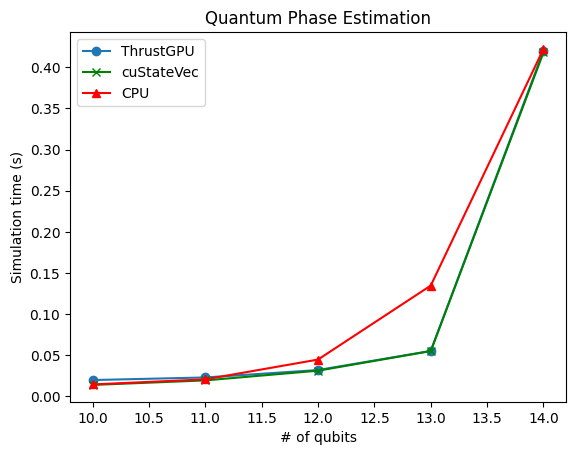

In [24]:
# plt.yscale("log")
plt.title('Quantum Phase Estimation')
plt.plot(qubits_list, time_thrust, marker="o", label='ThrustGPU')
plt.plot(qubits_list, time_cuStateVec, 'g', marker="x", label='cuStateVec')
plt.plot(qubits_list, time_CPU, 'r', marker="^", label='CPU')
plt.legend()
plt.xlabel("# of qubits")
plt.ylabel("Simulation time (s)")